In [1]:
import torch 
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [4]:
if torch.cuda.is_available() :
    DEVICE = torch.device('cuda')
else :
    DEVICE = torch.device('cpu')
print(torch.cuda.get_device_name(), '\t', 'torch Version : ', torch.__version__)

NVIDIA GeForce GTX 1650 	 torch Version :  1.12.0


In [5]:
BATCH_SIZE = 64
EPOCHS = 100

In [7]:
train_dataset = datasets.MNIST(root='../../data/MNIST/',
                                download=True,
                                train=True,
                                transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='../../data/MNIST/',
                                download=True,
                                train=False,
                                transform=transforms.ToTensor())

In [8]:

train_loader = torch.utils.data.DataLoader(train_dataset,
                                            shuffle=True,
                                            batch_size = BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                            shuffle=False,
                                            batch_size = BATCH_SIZE)

In [9]:
for (X_train, y_train) in train_loader:
    print(X_train.size(), y_train.size())
    print(X_train.type(), y_train.type())
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.FloatTensor torch.LongTensor


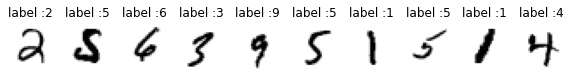

In [12]:
pltsize = 1
plt.figure(figsize=(pltsize * 10, pltsize))
for i in range(10) :
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap='gray_r')
    plt.title('label :' + str(y_train[i].item()))

In [91]:
del model

In [114]:
from torch import dropout


class Net(nn.Module) :
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 64)
        self.fc2 = nn.LSTM(input_size= 64, hidden_size = 128, dropout = 0.25)
        self.fc3 = nn.GRU(input_size = 128, hidden_size = 256, dropout = 0.25)
        self.fc4 = nn.Linear(256, 64)
        self.fc5 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.reshape(-1, 28*28)
        x = self.fc1(x)
        x, _ = self.fc2(x)
        x =  F.relu(x)
        x, _ = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        x = F.log_softmax(x)
        return x

In [115]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
criterion = nn.CrossEntropyLoss()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): LSTM(64, 128, dropout=0.25)
  (fc3): GRU(128, 256, dropout=0.25)
  (fc4): Linear(in_features=256, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
)


In [116]:
def train(model, train_loader, optimizer, log_intervals = 100):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        output = model(image)
        optimizer.zero_grad()
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_intervals == 0:
            print('Train_Epoch : {}, [{}/{}]({:.0f}%)\tTrain_Loss : {:.4f}'.format(
                Epoch, batch_idx * len(image), len(train_loader.dataset),
                batch_idx * 100 / len(train_loader), loss.item()
            ))

In [117]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    test_loss = 0
    for image, label in test_loader:
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        output = model(image)
        test_loss += criterion(output, label)
        prediction = output.max(1, keepdim=True)[1]
        correct +=  prediction.eq(label.view_as(prediction)).sum().item()
    test_loss /= len(test_loader)
    test_accuracy = correct * 100 / len(test_loader.dataset)
    return test_loss, test_accuracy

In [118]:
es = 0
best_accuracy = 0

for Epoch in range(1, EPOCHS + 1 ):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('\nEpoch : {}\tTest_loss : {:.4f}\tTest_accuracy : {:.2f}%\n'.format(
        Epoch, test_loss, test_accuracy
    ))

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model = model
        es = 0
    else : 
        es += 1

    if es == 30:
        break

C:\Users\Admin\AppData\Local\Temp\ipykernel_26064\4181537889.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train_Epoch : 1, [0/60000](0%)	Train_Loss : 2.2939
Train_Epoch : 1, [6400/60000](11%)	Train_Loss : 1.3171
Train_Epoch : 1, [12800/60000](21%)	Train_Loss : 1.0035
Train_Epoch : 1, [19200/60000](32%)	Train_Loss : 0.9063
Train_Epoch : 1, [25600/60000](43%)	Train_Loss : 0.6590
Train_Epoch : 1, [32000/60000](53%)	Train_Loss : 0.5919
Train_Epoch : 1, [38400/60000](64%)	Train_Loss : 0.6112
Train_Epoch : 1, [44800/60000](75%)	Train_Loss : 0.6824
Train_Epoch : 1, [51200/60000](85%)	Train_Loss : 0.8441
Train_Epoch : 1, [57600/60000](96%)	Train_Loss : 0.4290

Epoch : 1	Test_loss : 0.4472	Test_accuracy : 86.79%

Train_Epoch : 2, [0/60000](0%)	Train_Loss : 0.3036
Train_Epoch : 2, [6400/60000](11%)	Train_Loss : 0.5648
Train_Epoch : 2, [12800/60000](21%)	Train_Loss : 0.4350
Train_Epoch : 2, [19200/60000](32%)	Train_Loss : 0.5339
Train_Epoch : 2, [25600/60000](43%)	Train_Loss : 0.4646
Train_Epoch : 2, [32000/60000](53%)	Train_Loss : 0.8054
Train_Epoch : 2, [38400/60000](64%)	Train_Loss : 0.3193
Train_

KeyboardInterrupt: 

In [119]:
print('최고 정확도 : ', best_accuracy)

최고 정확도 :  90.09
